The dataset for this notebook can be found [here](https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("car_prices.csv").dropna()
df.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


This dataset has a pretty big issue, check the selling date. But we're going to ignore that for this exercise.

In [5]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from skrub import SelectCols

pipe = make_union(
    SelectCols(["mmr"]),
    make_pipeline(
        SelectCols(["year", "condition", "odometer"]),
        StandardScaler()
    ),
    make_pipeline(
        SelectCols(["make", "model", "body", "transmission", "color"]),
        OneHotEncoder(sparse_output=False)
    )
)

X_demo = pipe.fit_transform(df)

In [70]:
# X_demo[0]

In [58]:
X_demo.shape

(472325, 932)

In [9]:
from lancedb.pydantic import Vector, LanceModel

class CarVector(LanceModel):
    vector: Vector(X_demo.shape[1])
    id: int
    sellingprice: int

In [61]:
! rm -rf .lancedb/

In [62]:
import lancedb 

db = lancedb.connect("./.lancedb")

In [63]:
batch = [{"vector": v, "id": idx, "sellingprice": p} 
         for idx, (p, v) in enumerate(zip(df['sellingprice'], X_demo))]

tbl = db.create_table(
    "orig-model", 
    schema=CarVector, 
    on_bad_vectors='drop', # This is an interesting one by the way! 
    data=batch
)

In [68]:
%%time

tbl.search(X_demo[0]).limit(5).to_pandas()

CPU times: user 472 ms, sys: 980 ms, total: 1.45 s
Wall time: 400 ms


,vector,id,sellingprice,_distance
0,"[20500.0, 1.252966, -1.9398257, -0.9638657, 0....",0,21500,0.000000
1,"[20500.0, 1.252966, -1.9398257, -1.0125569, 0....",269963,20700,0.002371
2,"[20500.0, 1.252966, -1.9398257, -1.0395306, 0....",225270,20800,0.005725
3,"[20500.0, 1.252966, -1.9398257, -0.96946836, 0...",79,20500,2.000031
4,"[20500.0, 1.252966, -1.9398257, -0.98242575, 0...",151732,19700,2.000345


In [55]:
%%time 

tbl.create_index()

[2024-04-19T08:57:56Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 93 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-04-19T08:57:56Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 90 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-04-19T08:57:56Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 102 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-04-19T08:57:56Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 87 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-04-19T08:57:56Z WARN  lance_l

CPU times: user 7min 17s, sys: 15.4 s, total: 7min 33s
Wall time: 1min 18s


In [56]:
%%time 

tbl.search(X_demo[0]).limit(20).to_pandas()

thread 'lance-cpu' panicked at /Users/runner/work/lance/lance/rust/lance-index/src/vector/pq/utils.rs:72:14:
range end index 221184 out of range for slice of length 220884
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
thread 'lance-cpu' panicked at /Users/runner/work/lance/lance/rust/lance-index/src/vector/pq/utils.rs:72:14:
range end index 221184 out of range for slice of length 220884
thread 'lance-cpu' panicked at /Users/runner/work/lance/lance/rust/lance-index/src/vector/pq/utils.rs:72:14:
range end index 221184 out of range for slice of length 220884
thread 'lance-cpu' panicked at thread '/Users/runner/work/lance/lance/rust/lance-index/src/vector/pq/utils.rslance-cpu:' panicked at 72/Users/runner/work/lance/lance/rust/lance-index/src/vector/pq/utils.rs::1472:
:range end index 221184 out of range for slice of length 22088414
:
range end index 221184 out of range for slice of length 220884
thread 'lance-cpu' panicked at /Users/runner/work/lance/lance/

OSError: Io error: Execution error: External error: Execution error: ExecNode(Take): thread panicked: task 455140 panicked

That's interesting! We managed to break it ... but ... the default from LanceDB is still faster that scikit-learn. So LanceDB still offers something nice here.

In [24]:
from sklearn.neighbors import KNeighborsRegressor

mod = KNeighborsRegressor(n_neighbors=5).fit(X_demo, df['sellingprice'])

In [25]:
%%time

mod.predict([X_demo[0]])

CPU times: user 878 ms, sys: 35 ms, total: 913 ms
Wall time: 256 ms


array([20640.])

In [26]:
mod_brute = KNeighborsRegressor(n_neighbors=5, algorithm="brute").fit(X_demo, df['sellingprice'])

In [27]:
%%time

mod_brute.predict([X_demo[0]])

CPU times: user 893 ms, sys: 28.4 ms, total: 922 ms
Wall time: 197 ms


array([20640.])

Let's do something interesting here.

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.ensemble import HistGradientBoostingRegressor

In [39]:
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeKNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=5, coef_fit=False, weights="uniform"):
        self.n_neighbors = n_neighbors
        self.coef_fit = coef_fit
        self.weights = weights

    def fit(self, X, y):
        if self.coef_fit:
            self.mod_ = Ridge(fit_intercept=False).fit(X, y)
            X = X * mod.coef_
        self.knn_ = KNeighborsRegressor(n_neighbors=self.n_neighbors, weights=self.weights).fit(X, y)
        return self

    def predict(self, X):
        if self.coef_fit:
            X = X * mod.coef_
        return self.knn_.predict(X)

In [40]:
cv = GridSearchCV(
    RidgeKNNRegressor(), 
    param_grid={
        "coef_fit": [True, False], 
        "n_neighbors": [1, 5, 10, 20, 50],
        "weights": ["uniform", "distance"]
    }, 
    cv=5, 
    n_jobs=-1, 
    scoring={
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    },
    refit=False,
)

In [41]:
X_demo.shape

(472325, 932)

In [44]:
%%time 

cv.fit(X_demo[:10000], df['sellingprice'][:10000])

CPU times: user 230 ms, sys: 165 ms, total: 395 ms
Wall time: 20.7 s


GridSearchCV(cv=5, estimator=RidgeKNNRegressor(), n_jobs=-1,
             param_grid={'coef_fit': [True, False],
                         'n_neighbors': [1, 5, 10, 20, 50],
                         'weights': ['uniform', 'distance']},
             refit=False,
             scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'mse': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict')})

In [45]:
df_res = pd.DataFrame(cv.cv_results_)
df_res[[c for c in df_res.columns if 'mae' in c] + ['param_coef_fit', 'param_n_neighbors', 'param_weights']].sort_values('mean_test_mae')

,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae,rank_test_mae,param_coef_fit,param_n_neighbors,param_weights
11,-1940.070500,-1761.664500,-1828.448000,-1778.065000,-1791.139500,-1819.877500,64.004253,19,False,1,distance
10,-1940.070500,-1761.664500,-1828.448000,-1778.065000,-1791.139500,-1819.877500,64.004253,19,False,1,uniform
0,-1815.121500,-1645.337000,-1790.349500,-1631.528500,-1631.737500,-1702.814800,82.112770,17,True,1,uniform
1,-1815.121500,-1645.337000,-1790.349500,-1631.528500,-1631.737500,-1702.814800,82.112770,17,True,1,distance
13,-1578.264476,-1522.613751,-1443.445629,-1474.384321,-1370.531350,-1477.847905,70.427019,16,False,5,distance
19,-1560.274791,-1467.937462,-1632.081578,-1362.650707,-1305.568101,-1465.702528,120.742378,15,False,50,distance
17,-1560.729366,-1472.482430,-1557.710191,-1381.978660,-1312.605975,-1457.101324,97.590793,14,False,20,distance
12,-1517.916200,-1484.860500,-1454.129600,-1445.056200,-1364.866100,-1453.365720,51.108708,13,False,5,uniform
15,-1544.420701,-1480.942328,-1461.993924,-1418.657078,-1321.944451,-1445.591696,73.891796,12,False,10,distance
18,-1537.158860,-1425.393260,-1695.761350,-1290.449710,-1269.354390,-1443.623514,159.051333,11,False,50,uniform


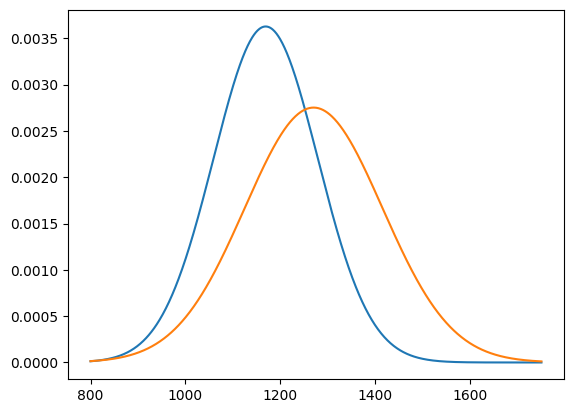

In [46]:
import matplotlib.pylab as plt 
from scipy import stats
import numpy as np

x = np.linspace(800, 1750, 1000)
plt.plot(x, stats.norm(1169, 110).pdf(x))
plt.plot(x, stats.norm(1270, 145).pdf(x))

In [51]:
cv_hgbm = GridSearchCV(
    HistGradientBoostingRegressor(), 
    param_grid={"learning_rate": [0.05], 'loss': ['absolute_error', 'squared_error'], }, 
    cv=5, 
    n_jobs=1, 
    scoring={
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    },
    refit=False,
)

In [52]:
%%time

cv_hgbm.fit(X_demo[:10000], df['sellingprice'][:10000])

CPU times: user 4min 5s, sys: 1min 42s, total: 5min 47s
Wall time: 1min


GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(), n_jobs=1,
             param_grid={'learning_rate': [0.05],
                         'loss': ['absolute_error', 'squared_error']},
             refit=False,
             scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'mse': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict')})

In [54]:
%%time 

cv_hgbm.cv_results_['mean_test_mae']

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 13.1 µs


array([-1298.7905559 , -1275.36216677])